In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor

from tabulate import tabulate

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from keras.utils.vis_utils import plot_model

import pickle

# Загрузка данных

In [2]:
df_bp  = pd.read_excel(
    '/content/drive/MyDrive/Datasets/MGTU-DS-VKR-2022/X_bp.xlsx', index_col=0)
df_nup = pd.read_excel(
    '/content/drive/MyDrive/Datasets/MGTU-DS-VKR-2022/X_nup.xlsx', index_col=0)
print(df_bp.shape)
print(df_nup.shape)

(1023, 10)
(1040, 3)


👆 Датасет «X_nup.xlsx» имеет на 17 записей больше, чем «X_bp.xlsx».
___

In [3]:
df_bp.head(5)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2"
0.0,1.857143,2030.0,738.736842,30.00,22.267857,100.000000,210.0,70.0,3000.0,220.0
1.0,1.857143,2030.0,738.736842,50.00,23.750000,284.615385,210.0,70.0,3000.0,220.0
2.0,1.857143,2030.0,738.736842,49.90,33.000000,284.615385,210.0,70.0,3000.0,220.0
3.0,1.857143,2030.0,738.736842,129.00,21.250000,300.000000,210.0,70.0,3000.0,220.0
4.0,2.771331,2030.0,753.000000,111.86,22.267857,284.615385,210.0,70.0,3000.0,220.0


In [4]:
df_nup.head(5)

,"Угол нашивки, град",Шаг нашивки,Плотность нашивки
0.0,0.0,4.0,57.0
1.0,0.0,4.0,60.0
2.0,0.0,4.0,70.0
3.0,0.0,5.0,47.0
4.0,0.0,5.0,57.0


# Анализ и предобработка данных

## Анализ типов данных

In [5]:
print(df_bp.dtypes)
print()
print(df_nup.dtypes)

Соотношение матрица-наполнитель         float64
Плотность, кг/м3                        float64
модуль упругости, ГПа                   float64
Количество отвердителя, м.%             float64
Содержание эпоксидных групп,%_2         float64
Температура вспышки, С_2                float64
Поверхностная плотность, г/м2           float64
Модуль упругости при растяжении, ГПа    float64
Прочность при растяжении, МПа           float64
Потребление смолы, г/м2                 float64
dtype: object

Угол нашивки, град    float64
Шаг нашивки           float64
Плотность нашивки     float64
dtype: object


👆 Не смотря на то, что в данных присутствуют целочисленные значения, все типы по-умолчанию выбраны как числа с плавающей запятой двойной точности. Строковых данных нет. 
___

## Анализ пропусков

In [6]:
print("df_bp количество пропущенных значений :", df_bp.isna().sum().sum())
print("df_nup количество пропущенных значений :", df_nup.isna().sum().sum())
print()
print("df_bp количество NULL значений :", df_bp.isnull().sum().sum())
print("df_nup количество NULL значений :", df_nup.isnull().sum().sum())

df_bp количество пропущенных значений : 0
df_nup количество пропущенных значений : 0

df_bp количество NULL значений : 0
df_nup количество NULL значений : 0


👆 Пропуски и нулевые значения отсутствуют
___

## Анализ значений

In [7]:
print(df_bp.nunique())
print()
print(df_nup.nunique())

Соотношение матрица-наполнитель         1014
Плотность, кг/м3                        1013
модуль упругости, ГПа                   1020
Количество отвердителя, м.%             1005
Содержание эпоксидных групп,%_2         1004
Температура вспышки, С_2                1003
Поверхностная плотность, г/м2           1004
Модуль упругости при растяжении, ГПа    1004
Прочность при растяжении, МПа           1004
Потребление смолы, г/м2                 1003
dtype: int64

Угол нашивки, град       2
Шаг нашивки           1006
Плотность нашивки     1005
dtype: int64


👆 Датасеты имеет не уникальные (дублирующиеся) значения.

Угол нашивки с виду представляет бинарный параметр, но т.к. предоставлен усеченный набор данных, то считаем, что параметр может и иметь другие углы нашивки, не попавшие в данный датасет.
___

## Анализ дублирующихся значений и нулевых строк

In [8]:
print('Соотношение матрица-наполнитель: ',      
      df_bp.duplicated(subset='Соотношение матрица-наполнитель').sum())
print('Плотность, кг/м3: ',                     
      df_bp.duplicated(subset='Плотность, кг/м3').sum())
print('модуль упругости, ГПа: ',               
      df_bp.duplicated(subset='модуль упругости, ГПа').sum())
print('Количество отвердителя, м.%: ',          
      df_bp.duplicated(subset='Количество отвердителя, м.%').sum())
print('Содержание эпоксидных групп,%_2: ',      
      df_bp.duplicated(subset='Содержание эпоксидных групп,%_2').sum())
print('Температура вспышки, С_2: ',             
      df_bp.duplicated(subset='Температура вспышки, С_2').sum())
print('Поверхностная плотность, г/м2: ',        
      df_bp.duplicated(subset='Поверхностная плотность, г/м2').sum())
print('Модуль упругости при растяжении, ГПа: ', 
      df_bp.duplicated(subset='Модуль упругости при растяжении, ГПа').sum())
print('Прочность при растяжении, МПа: ',        
      df_bp.duplicated(subset='Прочность при растяжении, МПа').sum())
print('Потребление смолы, г/м2: ',              
      df_bp.duplicated(subset='Потребление смолы, г/м2').sum())
print('df_bp: ',                                
      df_bp.duplicated(subset=['Соотношение матрица-наполнитель', 
                               'Плотность, кг/м3',
                               'модуль упругости, ГПа',
                               'Количество отвердителя, м.%',
                               'Содержание эпоксидных групп,%_2',
                               'Температура вспышки, С_2',
                               'Поверхностная плотность, г/м2',
                               'Модуль упругости при растяжении, ГПа',
                               'Прочность при растяжении, МПа',
                               'Потребление смолы, г/м2']).sum())
print()
print('Шаг нашивки: ',        
      df_nup.duplicated(subset=['Шаг нашивки']).sum())
print('Плотность нашивки: ',  
      df_nup.duplicated(subset=['Плотность нашивки']).sum())
print('df_nup: ',             
      df_nup.duplicated(subset=['Шаг нашивки', 'Плотность нашивки']).sum())
print()
print('Количество нулевых строк df_bp: ',  
      (df_bp[df_bp['Соотношение матрица-наполнитель'] == 0]
      [df_bp['Плотность, кг/м3'] == 0]
      [df_bp['модуль упругости, ГПа'] == 0]
      [df_bp['Количество отвердителя, м.%'] == 0]
      [df_bp['Содержание эпоксидных групп,%_2'] == 0]
      [df_bp['Температура вспышки, С_2'] == 0]
      [df_bp['Поверхностная плотность, г/м2'] == 0]
      [df_bp['Модуль упругости при растяжении, ГПа'] == 0]
      [df_bp['Прочность при растяжении, МПа'] == 0]
      [df_bp['Потребление смолы, г/м2'] == 0]).shape[0])
print()
print('Количество нулевых строк df_nup: ', 
      (df_nup[(df_nup['Шаг нашивки'] == 0)]
       [(df_nup['Плотность нашивки'] == 0)]).shape[0])

Соотношение матрица-наполнитель:  9
Плотность, кг/м3:  10
модуль упругости, ГПа:  3
Количество отвердителя, м.%:  18
Содержание эпоксидных групп,%_2:  19
Температура вспышки, С_2:  20
Поверхностная плотность, г/м2:  19
Модуль упругости при растяжении, ГПа:  19
Прочность при растяжении, МПа:  19
Потребление смолы, г/м2:  20
df_bp:  0

Шаг нашивки:  34
Плотность нашивки:  35
df_nup:  19

Количество нулевых строк df_bp:  0

Количество нулевых строк df_nup:  1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:48: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

👆 Исключим далее их из датасетов дублирующиеся данные и нелувые строки.
___

## Удаление дублирующихся значений и нулевых строк

In [9]:
df_bp.drop_duplicates()
df_bp.drop_duplicates(subset='Соотношение матрица-наполнитель', inplace=True)
df_bp.drop_duplicates(subset='Плотность, кг/м3', inplace=True)
df_bp.drop_duplicates(subset='модуль упругости, ГПа', inplace=True)
df_bp.drop_duplicates(subset='Количество отвердителя, м.%', inplace=True)
df_bp.drop_duplicates(subset='Содержание эпоксидных групп,%_2', inplace=True)
df_bp.drop_duplicates(subset='Температура вспышки, С_2', inplace=True)
df_bp.drop_duplicates(subset='Поверхностная плотность, г/м2', inplace=True)
df_bp.drop_duplicates(subset='Модуль упругости при растяжении, ГПа',inplace=True)
df_bp.drop_duplicates(subset='Прочность при растяжении, МПа', inplace=True)
df_bp.drop_duplicates(subset='Потребление смолы, г/м2', inplace=True)
df_bp.drop_duplicates(subset=['Соотношение матрица-наполнитель',
                              'Количество отвердителя, м.%',
                              'Содержание эпоксидных групп,%_2',
                              'Температура вспышки, С_2',
                              'Поверхностная плотность, г/м2',
                              'Модуль упругости при растяжении, ГПа',
                              'Прочность при растяжении, МПа',
                              'Потребление смолы, г/м2'], inplace=True)

print('Размер df_bp после удаления дублирующихся значений: ', df_bp.shape)

df_nup.drop_duplicates(subset=['Шаг нашивки'], inplace=True)
df_nup.drop_duplicates(subset=['Плотность нашивки'], inplace=True)
df_nup.drop_duplicates(subset=['Шаг нашивки', 'Плотность нашивки'], inplace=True)
print('Размер df_nup после удаления дублирующихся значений: ', df_nup.shape)

print()
df_bp.drop(index=df_bp[df_bp['Соотношение матрица-наполнитель'] == 0]
           [df_bp['Количество отвердителя, м.%'] == 0]
           [df_bp['Содержание эпоксидных групп,%_2'] == 0]
           [df_bp['Температура вспышки, С_2'] == 0]
           [df_bp['Поверхностная плотность, г/м2'] == 0]
           [df_bp['Модуль упругости при растяжении, ГПа'] == 0]
           [df_bp['Прочность при растяжении, МПа'] == 0]
           [df_bp['Потребление смолы, г/м2'] == 0].index, inplace=True)
print('Размер df_bp после удаления нулевых строк: ', df_bp.shape)

df_nup.drop(index=df_nup[(df_nup['Шаг нашивки'] == 0)]
            [(df_nup['Плотность нашивки'] == 0)].index, inplace=True)
print('Размер df_nup после удаления нулевых строк: ', df_nup.shape)

df_bp.reset_index(drop=True, inplace=True) #скорректируем индексы
df_nup.reset_index(drop=True, inplace=True) #скорректируем индексы
print()

Размер df_bp после удаления дублирующихся значений:  (1002, 10)
Размер df_nup после удаления дублирующихся значений:  (1003, 3)

Размер df_bp после удаления нулевых строк:  (1002, 10)
Размер df_nup после удаления нулевых строк:  (1002, 3)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/li

👆 Т.к. после чистки данных размеры датасетов стали одинаковые и не заданы правила объединения датасетов, то объединим их как есть.
___

## Объединение датасетов

In [10]:
df_loaded = df_bp.join(df_nup, how='inner')
df = df_loaded.copy()
print(df.shape)

(1002, 13)


## Описательный статистика

In [11]:
df_describe = df.describe()
df_describe.T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1002.0,2.930165,0.913871,0.389403,2.317247,2.907832,3.552781,5.591742
"Плотность, кг/м3",1002.0,1975.675440,73.757180,1731.764635,1924.370115,1977.574305,2021.186675,2207.773481
"модуль упругости, ГПа",1002.0,740.098060,330.030446,2.436909,498.538615,741.148111,962.650230,1911.536477
"Количество отвердителя, м.%",1002.0,110.479158,28.396466,17.740275,92.054117,110.162666,130.240418,198.953207
"Содержание эпоксидных групп,%_2",1002.0,22.242882,2.404798,14.254985,20.563359,22.230761,23.981598,28.955094
"Температура вспышки, С_2",1002.0,285.739807,41.343587,100.000000,258.469516,285.853960,313.472775,413.273418
"Поверхностная плотность, г/м2",1002.0,482.649366,280.682398,0.603740,267.736782,451.944708,693.654483,1399.542362
"Модуль упругости при растяжении, ГПа",1002.0,73.326808,3.118688,64.054061,71.297280,73.247594,75.365124,82.682051
"Прочность при растяжении, МПа",1002.0,2467.050190,485.889244,1036.856605,2141.720311,2461.249253,2760.983489,3848.436732
"Потребление смолы, г/м2",1002.0,218.290295,59.840786,33.803026,179.147494,217.277006,257.488673,414.590628


👆 При незначительном разбросе значений соотношения матрица-наполнитель достаточно большой разброс по параметрам "Модуль упругости", "Поверхностная плотность", "Прочность при растяжении"
___

## Графики парных распределений

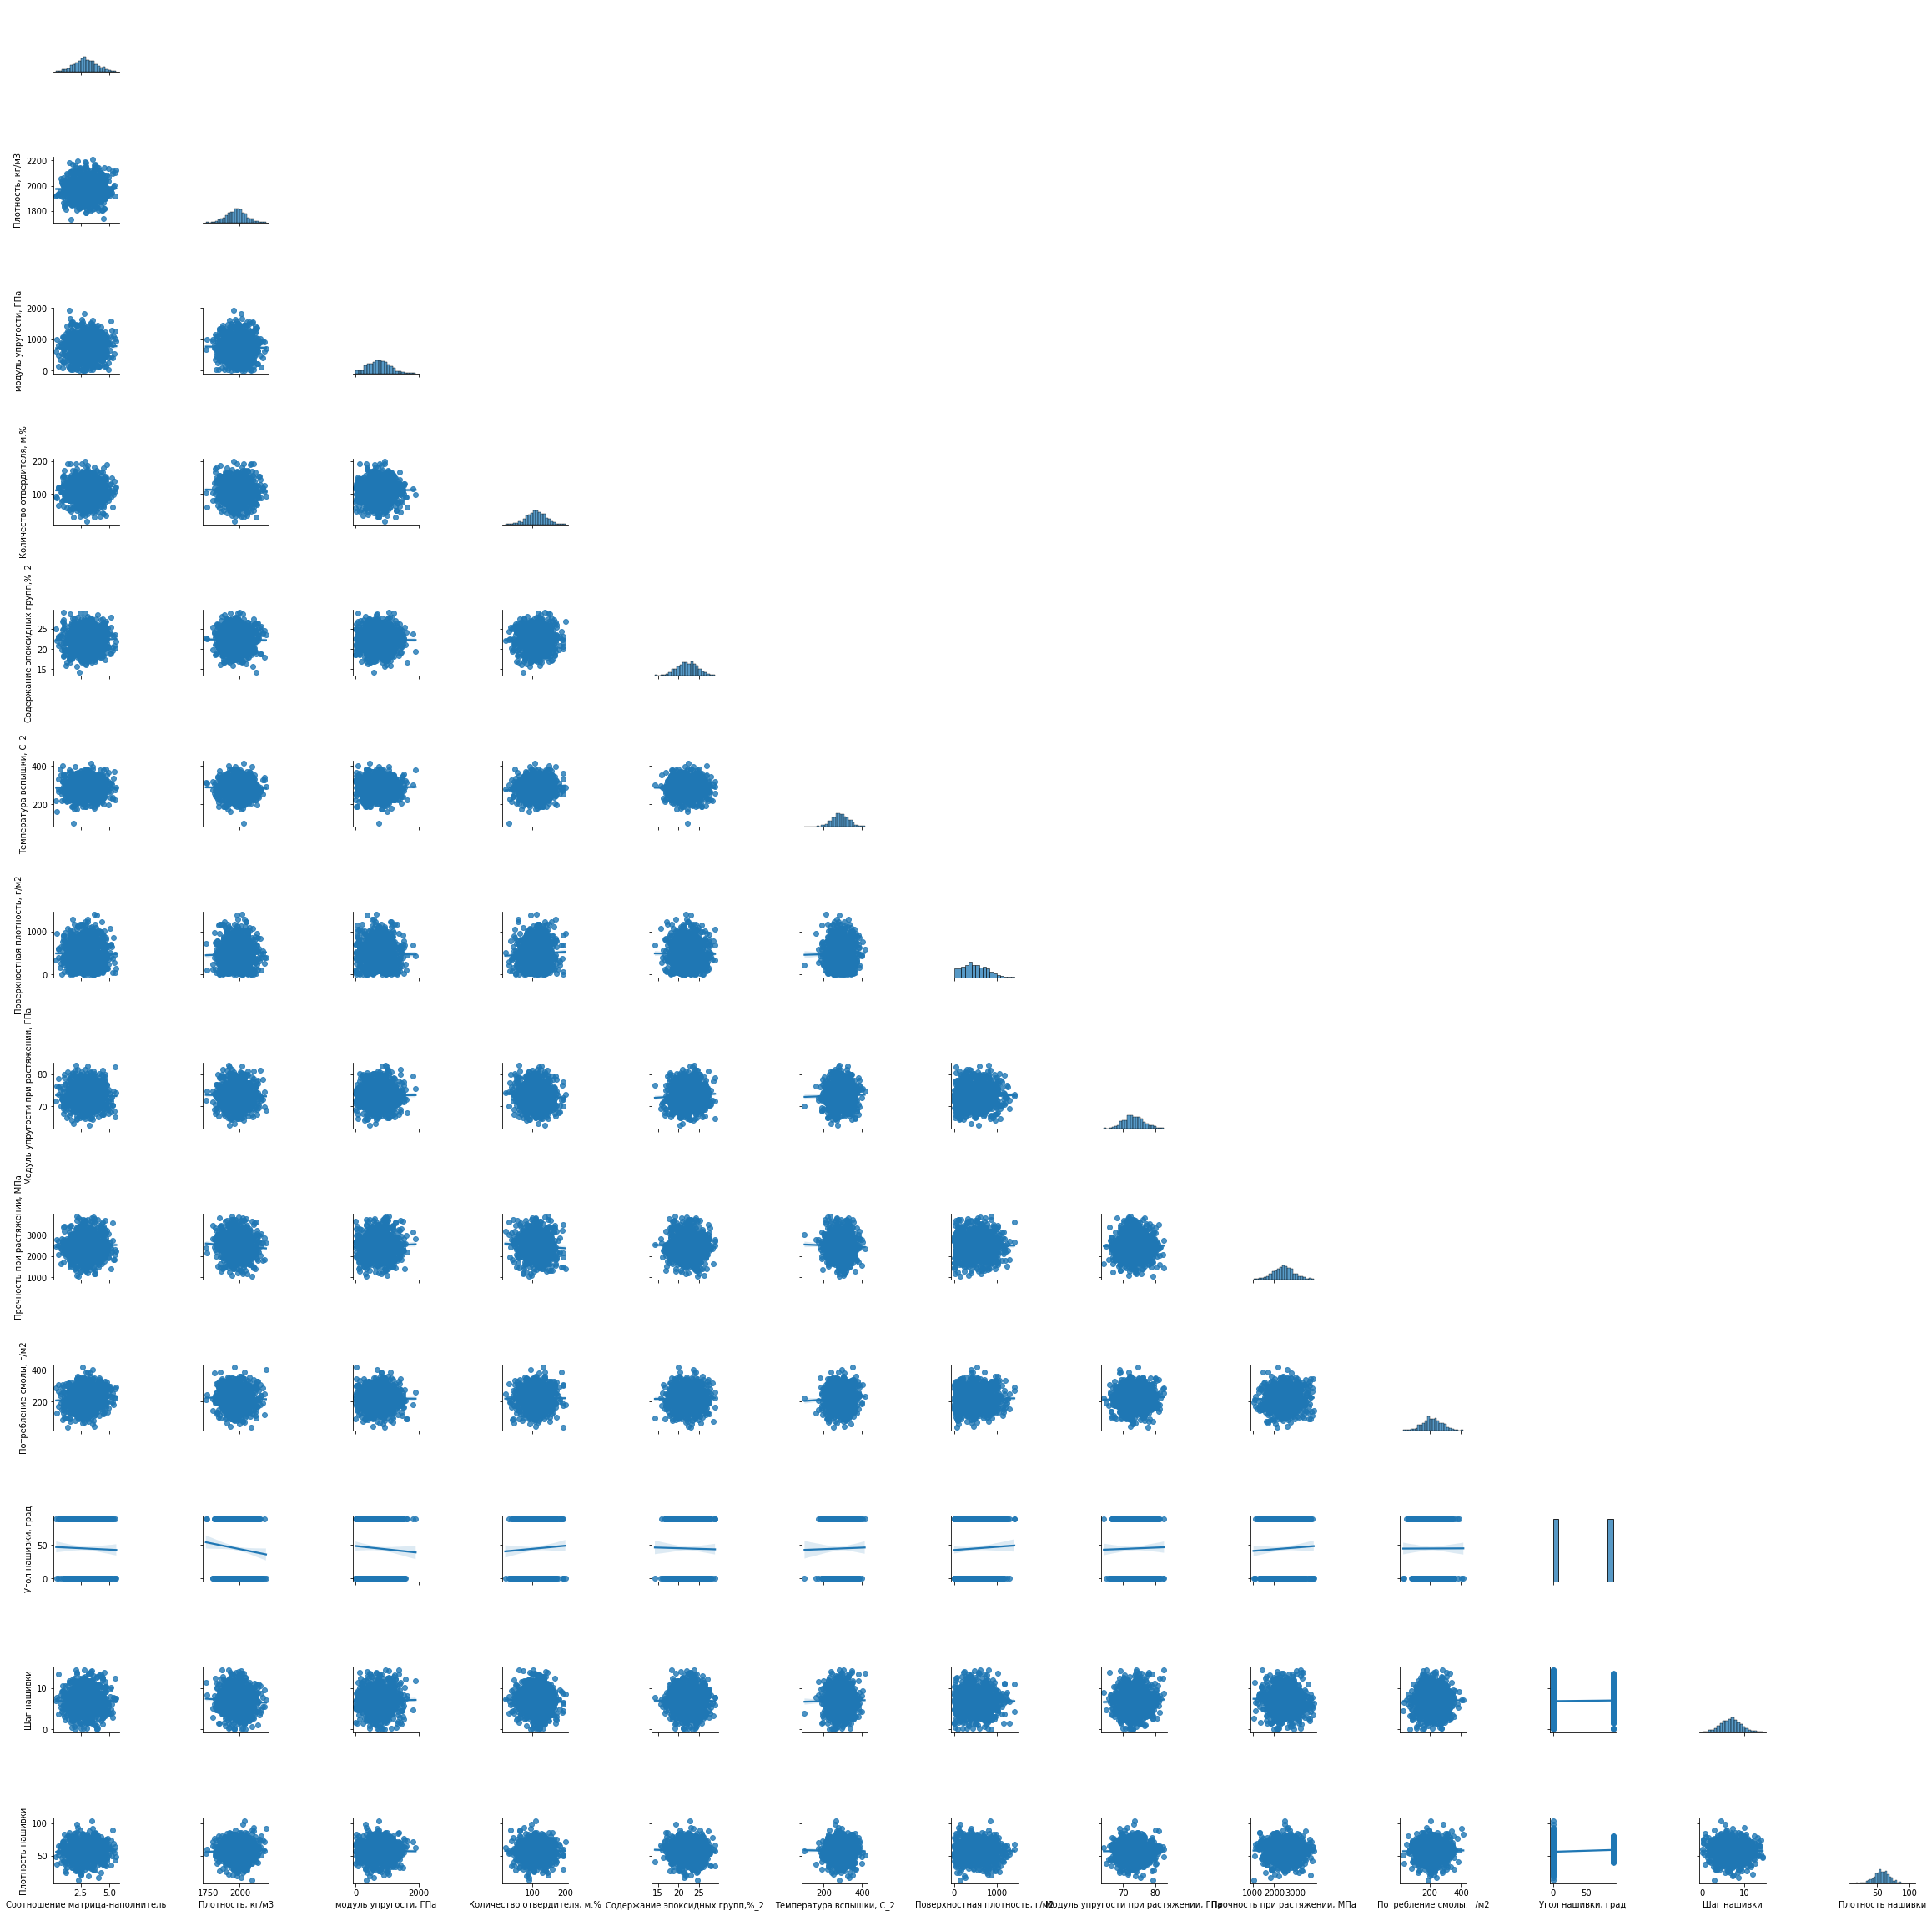

In [12]:
sns.pairplot(df, kind='reg', corner=True)

👆 Наблюдается наличие выбросов и отсутствие корреляции
___

In [13]:
df.skew()

Соотношение матрица-наполнитель         0.078677
Плотность, кг/м3                        0.048717
модуль упругости, ГПа                   0.100786
Количество отвердителя, м.%            -0.060912
Содержание эпоксидных групп,%_2        -0.031638
Температура вспышки, С_2               -0.046143
Поверхностная плотность, г/м2           0.381713
Модуль упругости при растяжении, ГПа    0.124148
Прочность при растяжении, МПа           0.080931
Потребление смолы, г/м2                 0.013748
Угол нашивки, град                      0.003998
Шаг нашивки                             0.111392
Плотность нашивки                      -0.143726
dtype: float64

👆 Коэффициент ассиметрии наиболее выражен на параметре "Поверхностная плотность" и имеет положительную асимметрию
___

Посмотрим ассиметрию на гистограмме

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f10a825a9d0>,
      dtype=object)

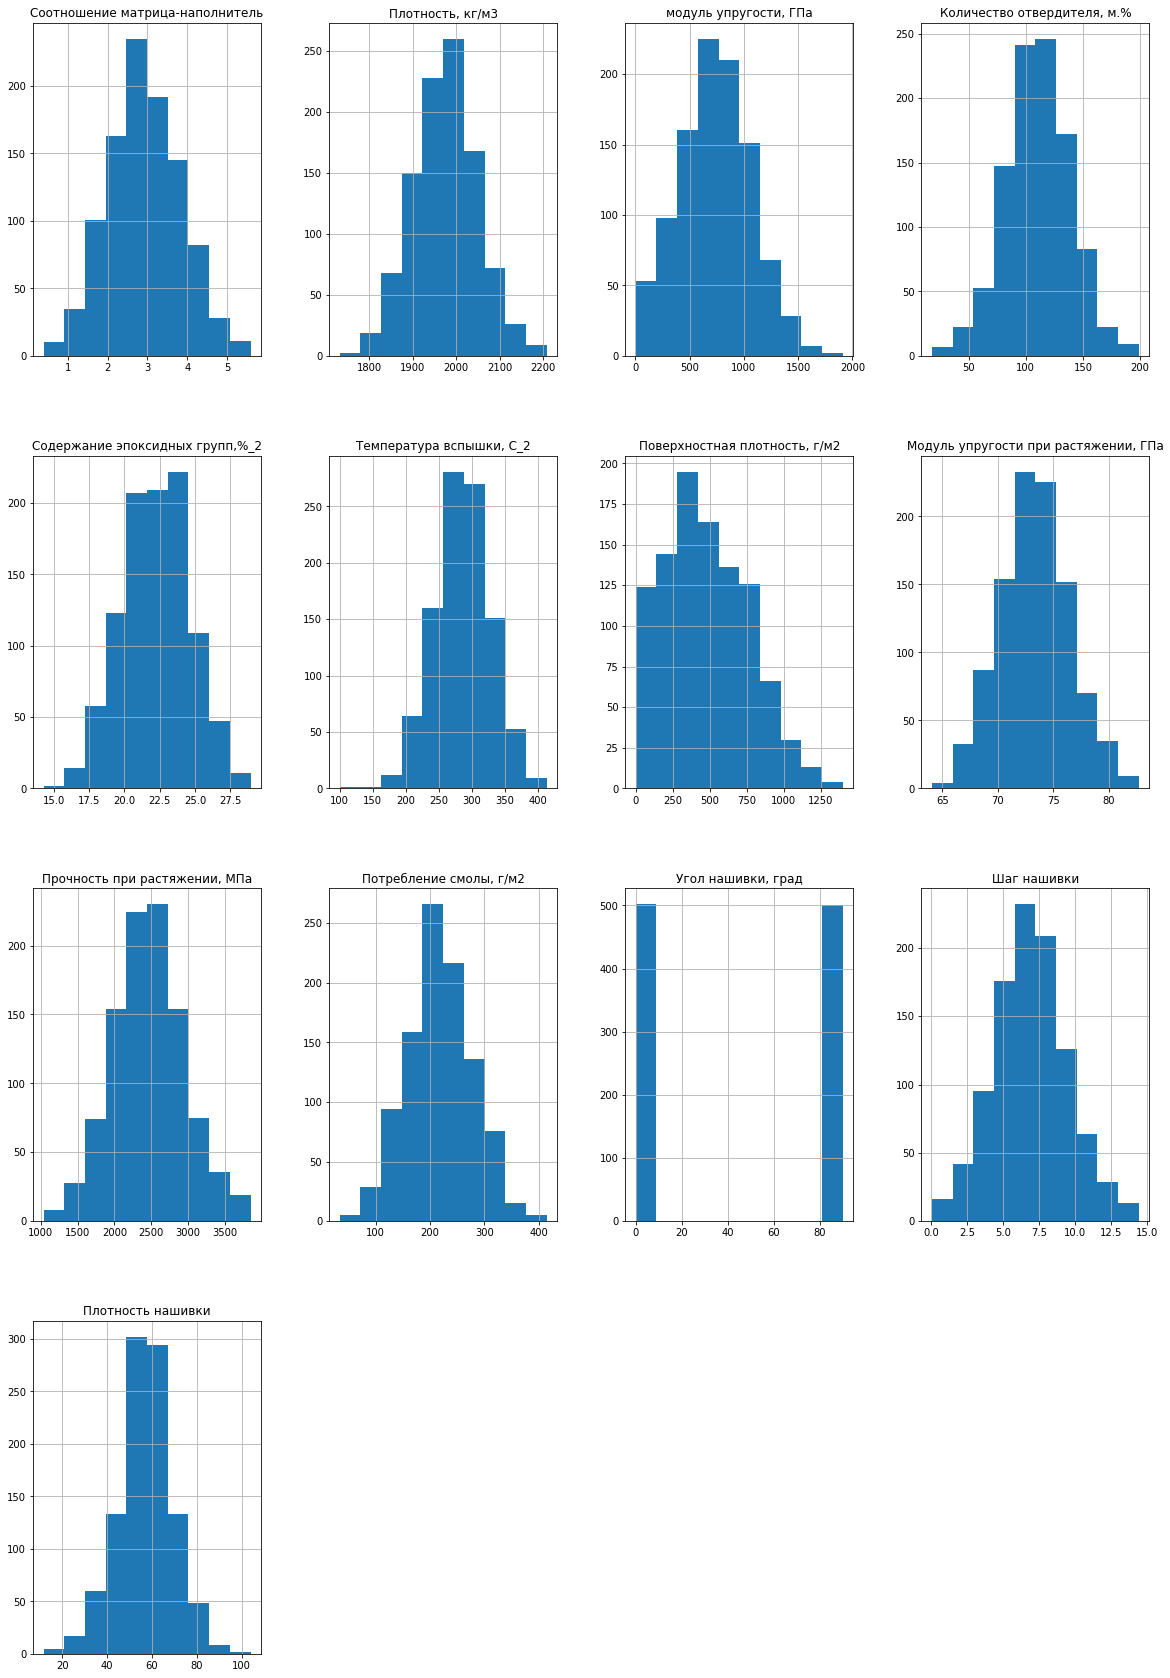

In [14]:
df.hist(bins=10, figsize=(20, 30))

👆 Гистограммы имеют нормальное распределение, за исключением параметров "Поверхностная плотность" и "Угол нашивки".
  ___

## Тепловая карта корреляции

In [15]:
df.corr().style.background_gradient(cmap='coolwarm', axis=None)

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
Соотношение матрица-наполнитель,1.000000,0.009730,0.032527,-0.013712,0.027562,-0.006074,-0.010999,-0.015854,0.033971,0.077503,-0.017127,0.004688,0.046602
"Плотность, кг/м3",0.009730,1.000000,-0.017816,-0.034475,-0.011411,-0.021585,0.037709,-0.021791,-0.072360,-0.026858,-0.063110,-0.060183,0.035423
"модуль упругости, ГПа",0.032527,-0.017816,1.000000,0.023692,-0.006371,0.031032,-0.017991,0.014716,0.047515,-0.008100,-0.037088,0.022978,-0.014466
"Количество отвердителя, м.%",-0.013712,-0.034475,0.023692,1.000000,0.013128,0.093342,0.050919,-0.073184,-0.070399,0.006991,0.029513,-0.037946,-0.001998
"Содержание эпоксидных групп,%_2",0.027562,-0.011411,-0.006371,0.013128,1.000000,-0.008176,-0.007539,0.064473,-0.030984,0.015714,-0.010078,-0.005978,-0.040914
"Температура вспышки, С_2",-0.006074,-0.021585,0.031032,0.093342,-0.008176,1.000000,0.019709,0.027867,-0.031211,0.060217,0.010441,0.018672,-0.017855
"Поверхностная плотность, г/м2",-0.010999,0.037709,-0.017991,0.050919,-0.007539,0.019709,1.000000,0.015804,0.012743,0.001643,0.030177,-0.009088,-0.005019
"Модуль упругости при растяжении, ГПа",-0.015854,-0.021791,0.014716,-0.073184,0.064473,0.027867,0.015804,1.000000,0.009559,0.044586,0.013813,0.039314,0.015160
"Прочность при растяжении, МПа",0.033971,-0.072360,0.047515,-0.070399,-0.030984,-0.031211,0.012743,0.009559,1.000000,0.028685,0.027367,-0.063270,-0.012882
"Потребление смолы, г/м2",0.077503,-0.026858,-0.008100,0.006991,0.015714,0.060217,0.001643,0.044586,0.028685,1.000000,0.001263,0.017253,0.015883


👆 Полученная тепловая карта так же свидетельствует об отсутствии явной корреляции между признаками.
___

## Анализ выбросов

Отобразим выбросы с помощью диаграммы ящика с усами

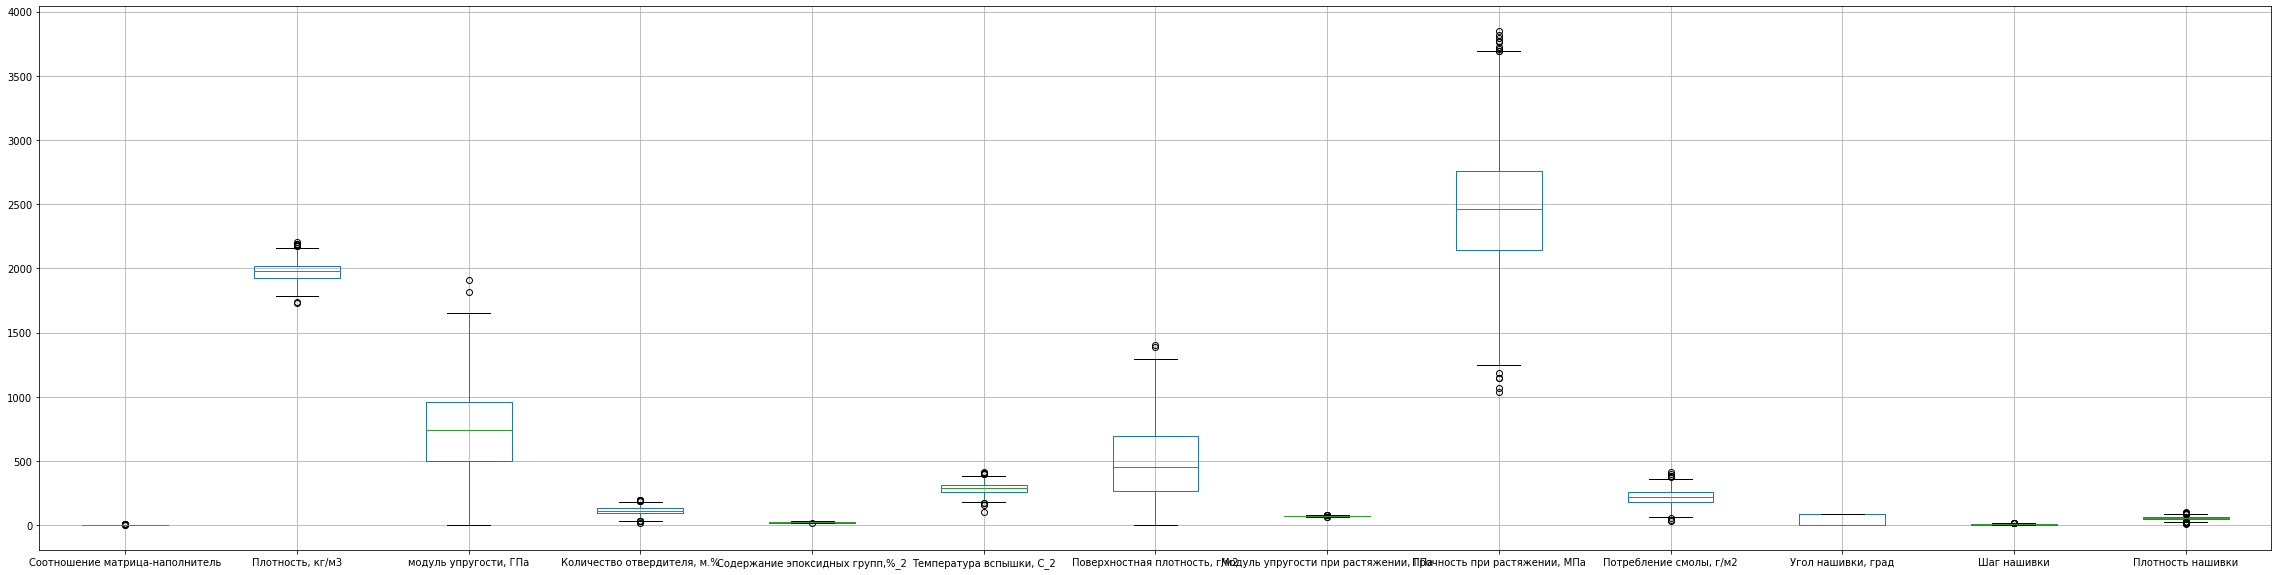

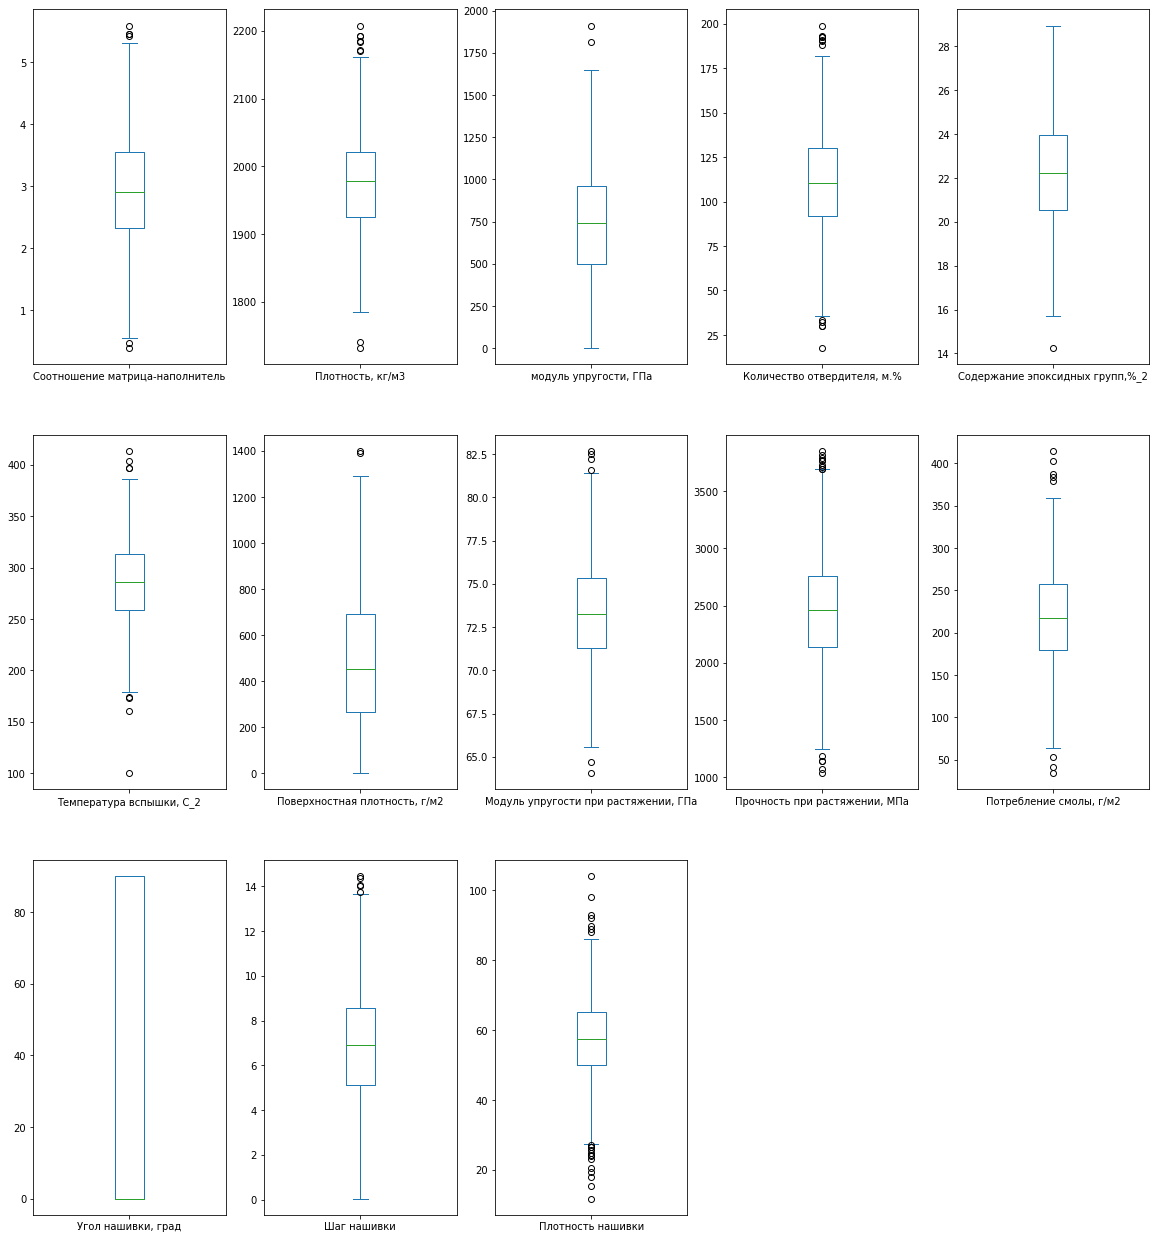

In [16]:
df.boxplot(figsize=(40, 10))

fig=plt.figure(figsize=(20, 30))
ax=fig.add_subplot(4, 5, 1)
df['Соотношение матрица-наполнитель'].plot.box()
ax=fig.add_subplot(4, 5, 2)
df['Плотность, кг/м3'].plot.box()
ax=fig.add_subplot(4, 5, 3)
df['модуль упругости, ГПа'].plot.box()
ax=fig.add_subplot(4, 5, 4)
df['Количество отвердителя, м.%'].plot.box()
ax=fig.add_subplot(4, 5, 5)
df['Содержание эпоксидных групп,%_2'].plot.box()
ax=fig.add_subplot(4, 5, 6)
df['Температура вспышки, С_2'].plot.box()
ax=fig.add_subplot(4, 5, 7)
df['Поверхностная плотность, г/м2'].plot.box()
ax=fig.add_subplot(4, 5, 8)
df['Модуль упругости при растяжении, ГПа'].plot.box()
ax=fig.add_subplot(4, 5, 9)
df['Прочность при растяжении, МПа'].plot.box()
ax=fig.add_subplot(4, 5, 10)
df['Потребление смолы, г/м2'].plot.box()
ax=fig.add_subplot(4, 5, 11)
df['Угол нашивки, град'].plot.box()
ax=fig.add_subplot(4, 5, 12)
df['Шаг нашивки'].plot.box()
ax=fig.add_subplot(4, 5, 13)
df['Плотность нашивки'].plot.box()

👆 Из диаграмм видно наличие выбросов
___

## Удаление шумов

Удаление данных, которые отклоняются от трех стандартных отклонений от среднего

In [17]:
df_describe = df.describe()
for column in df.columns:
  mean = df_describe.loc['mean', column]
  std = df_describe.loc['std', column]
  min = mean - 3*std
  max = mean + 3*std
  df.loc[df[column] < min, column] = np.nan
  df.loc[df[column] > max, column] = np.nan

df.dropna(inplace=True)
df.shape

(981, 13)

___

## Удаление выбросов


Удаление данных, которые превышают 1,5 межквартильного размаха

In [18]:
df_describe = df.describe()
for column in df.columns:
  q25 = df_describe.loc['25%', column]
  q75 = df_describe.loc['75%', column]
  intr_q = q75 - q25
  max = q75 + 1.5 * intr_q
  min = q25 - 1.5 * intr_q
  df.loc[df[column] < min, column] = np.nan
  df.loc[df[column] > max, column] = np.nan

df.dropna(inplace=True)
df.shape

(919, 13)

___

## Нормализация данных

In [19]:
df_norm = pd.DataFrame(data=MinMaxScaler().fit_transform(df), columns=df.keys())

In [20]:
df_norm.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,919.0,0.500285,0.188013,0.0,0.375674,0.495399,0.630121,1.0
"Плотность, кг/м3",919.0,0.501584,0.187496,0.0,0.369428,0.510015,0.623659,1.0
"модуль упругости, ГПа",919.0,0.446858,0.199830,0.0,0.301109,0.444285,0.583184,1.0
"Количество отвердителя, м.%",919.0,0.514035,0.185467,0.0,0.389190,0.512657,0.647038,1.0
"Содержание эпоксидных групп,%_2",919.0,0.493728,0.182223,0.0,0.366369,0.492531,0.625220,1.0
"Температура вспышки, С_2",919.0,0.514004,0.193129,0.0,0.382837,0.515364,0.646790,1.0
"Поверхностная плотность, г/м2",919.0,0.374700,0.215687,0.0,0.209840,0.353522,0.538725,1.0
"Модуль упругости при растяжении, ГПа",919.0,0.489157,0.191840,0.0,0.357792,0.485407,0.617966,1.0
"Прочность при растяжении, МПа",919.0,0.495848,0.186729,0.0,0.367349,0.492080,0.615393,1.0
"Потребление смолы, г/м2",919.0,0.521799,0.196439,0.0,0.388226,0.518199,0.654851,1.0


Данные до нормализации


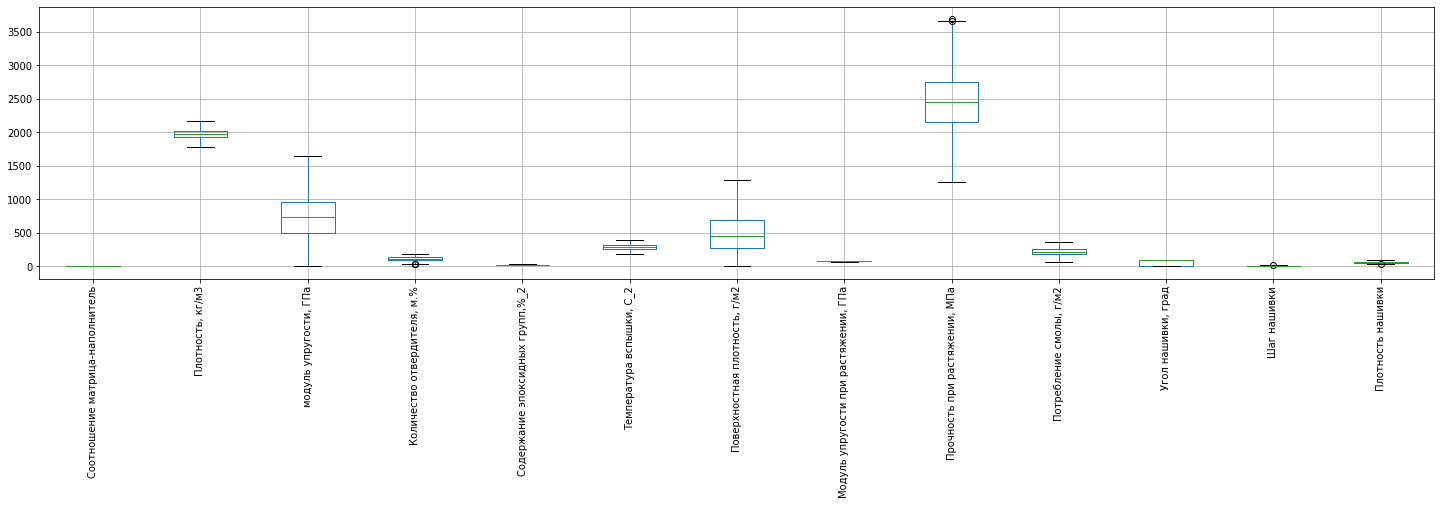

In [21]:
print("Данные до нормализации")
ax = df.boxplot(figsize=(25, 5))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Данные после нормализации


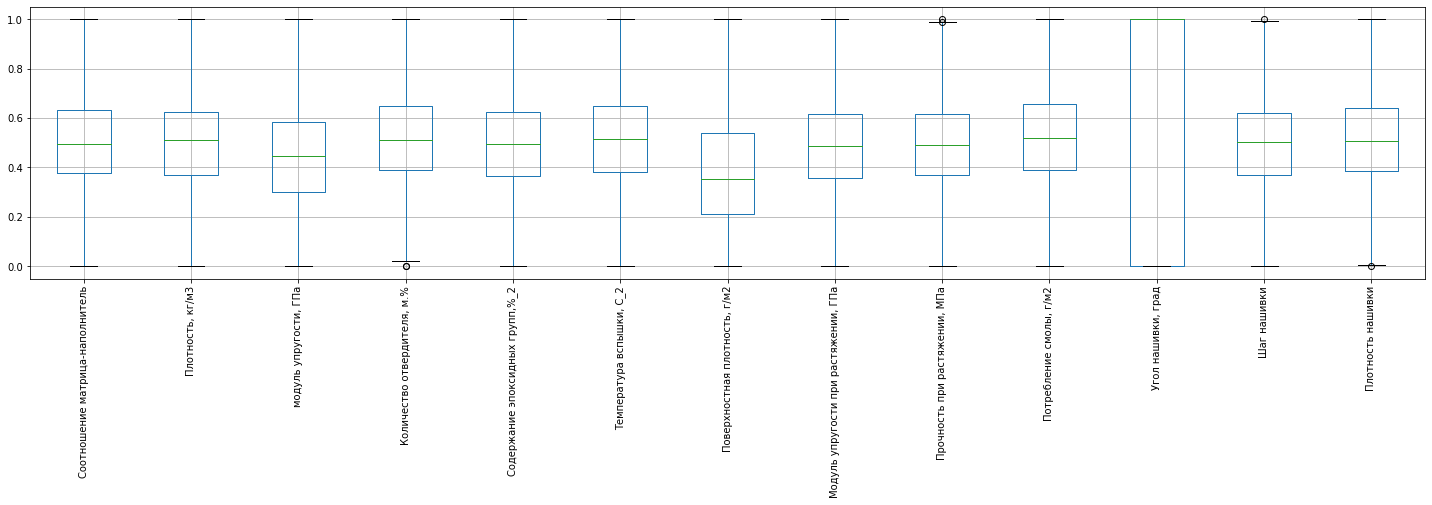

In [22]:
print("Данные после нормализации")
ax = df_norm.boxplot(figsize=(25, 5))
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

# Модели для прогноза модуля упругости при растяжении

In [23]:
X = df_norm.copy()
y = pd.DataFrame(data=X.pop('Модуль упругости при растяжении, ГПа'), 
                 columns=['Модуль упругости при растяжении, ГПа'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

print("Size of train data set: ",  X_train.shape)
print("Size of train label set: ", y_train.shape)
print("Size of test data set: ",   X_test.shape)
print("Size of test label set: ",  y_test.shape)

Size of train data set:  (643, 12)
Size of train label set:  (643, 1)
Size of test data set:  (276, 12)
Size of test label set:  (276, 1)


In [24]:
#Класс обертка
class Model:
  def __init__(self, model):
    self.model = model
    self.mae = 0
    self.mse = 0
    self.r2 = 0
    self.y_pred = 0

  def fit(self):
    self.model = self.model.fit(X_train, y_train)

  def predict(self):
    self.y_pred = self.model.predict(X_test)

  def fit_and_predict(self):
    self.fit()
    self.predict()

  def print_metrics(self):
    self.mae = mean_absolute_error(y_test, self.y_pred)
    self.mse = mean_squared_error(y_test, self.y_pred)
    self.r2 = r2_score(y_test, self.y_pred)

    print('MAE: ', self.mae)
    print('MSE: ', self.mse)
    print('R2: ', self.r2)

  def print_plot(self):
    a = plt.axes(aspect='equal')
    plt.scatter(y_test, self.y_pred)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказания')
    lims = [0, 1]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

## Линейная регрессия

MAE:  0.1596332777428042
MSE:  0.03858896225086502
R2:  -0.02597013662982328


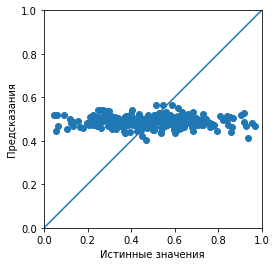

In [25]:
lr_mu = Model(LinearRegression())
lr_mu.fit_and_predict()
lr_mu.print_metrics()
lr_mu.print_plot()

##Дерево решений (+ GridSearchCV)

In [26]:
param_grid = {
   'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
   'max_depth' : [1, 3, 13, 23, 53]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10).fit(X_train, y_train)
print('Best params: ', grid.best_params_)
print('Best score: ', grid.best_score_)

Best params:  {'criterion': 'absolute_error', 'max_depth': 1}
Best score:  -0.01584959771618255


In [27]:
results = pd.DataFrame(grid.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
mean_fit_time,0.004557,0.005233,0.010765,0.01277,0.015326,0.003993,0.005718,0.011277,0.01355,0.013807,0.016525,0.035136,0.078265,0.085201,0.087668,0.005016,0.007092,0.01687,0.029477,0.053012
std_fit_time,0.001078,0.000376,0.000775,0.001406,0.002136,0.000471,0.000732,0.001752,0.001798,0.001787,0.001697,0.004242,0.013795,0.009366,0.013537,0.001442,0.000674,0.000776,0.00322,0.004561
mean_score_time,0.003504,0.003502,0.003736,0.003832,0.00505,0.002985,0.003542,0.003724,0.004499,0.003741,0.004277,0.004081,0.003998,0.004076,0.003888,0.00382,0.003672,0.003529,0.004296,0.00427
std_score_time,0.000599,0.00061,0.000694,0.000777,0.001452,0.000597,0.000826,0.000505,0.001031,0.000519,0.001174,0.000888,0.000523,0.000679,0.000704,0.001605,0.000655,0.000605,0.000747,0.001579
param_criterion,squared_error,squared_error,squared_error,squared_error,squared_error,friedman_mse,friedman_mse,friedman_mse,friedman_mse,friedman_mse,absolute_error,absolute_error,absolute_error,absolute_error,absolute_error,poisson,poisson,poisson,poisson,poisson
param_max_depth,1,3,13,23,53,1,3,13,23,53,1,3,13,23,53,1,3,13,23,53
params,"{'criterion': 'squared_error', 'max_depth': 1}","{'criterion': 'squared_error', 'max_depth': 3}","{'criterion': 'squared_error', 'max_depth': 13}","{'criterion': 'squared_error', 'max_depth': 23}","{'criterion': 'squared_error', 'max_depth': 53}","{'criterion': 'friedman_mse', 'max_depth': 1}","{'criterion': 'friedman_mse', 'max_depth': 3}","{'criterion': 'friedman_mse', 'max_depth': 13}","{'criterion': 'friedman_mse', 'max_depth': 23}","{'criterion': 'friedman_mse', 'max_depth': 53}","{'criterion': 'absolute_error', 'max_depth': 1}","{'criterion': 'absolute_error', 'max_depth': 3}","{'criterion': 'absolute_error', 'max_depth': 13}","{'criterion': 'absolute_error', 'max_depth': 23}","{'criterion': 'absolute_error', 'max_depth': 53}","{'criterion': 'poisson', 'max_depth': 1}","{'criterion': 'poisson', 'max_depth': 3}","{'criterion': 'poisson', 'max_depth': 13}","{'criterion': 'poisson', 'max_depth': 23}","{'criterion': 'poisson', 'max_depth': 53}"
split0_test_score,-0.003579,-0.00378,-0.817156,-1.027815,-1.251107,-0.003579,-0.00378,-0.787611,-1.05747,-1.209922,-0.000883,-0.031209,-0.527086,-0.479518,-0.698402,-0.001811,-0.001901,-0.037006,-0.240532,-0.373808
split1_test_score,-0.00854,-0.008898,-0.045179,-0.87385,-1.036226,-0.00854,-0.008898,-0.02633,-0.649917,-0.912183,-0.002358,0.011615,-0.681118,-0.400806,-0.653236,-0.005348,-0.00552,-0.059072,-0.010142,-0.608425
split2_test_score,-0.002159,0.006162,-0.144816,-0.3359,-0.387576,-0.002159,0.01482,-0.201658,-0.36021,-0.414125,-0.022352,0.007465,-0.251419,-0.68088,-0.814457,-0.004807,-0.005243,-0.05111,-0.070343,-0.484649


MAE:  0.1595797206364369
MSE:  0.037764722283860665
R2:  -0.004055953344309637


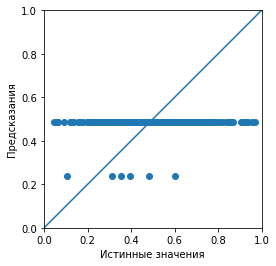

In [28]:
dt_mu = Model(model = DecisionTreeRegressor(criterion='absolute_error', max_depth=1))
dt_mu.fit_and_predict()
dt_mu.print_metrics()
dt_mu.print_plot()

[Text(0.5, 0.75, 'X[4] <= 0.098\nabsolute_error = 0.154\nsamples = 643\nvalue = 0.481'),
 Text(0.25, 0.25, 'absolute_error = 0.049\nsamples = 6\nvalue = 0.237'),
 Text(0.75, 0.25, 'absolute_error = 0.153\nsamples = 637\nvalue = 0.486')]

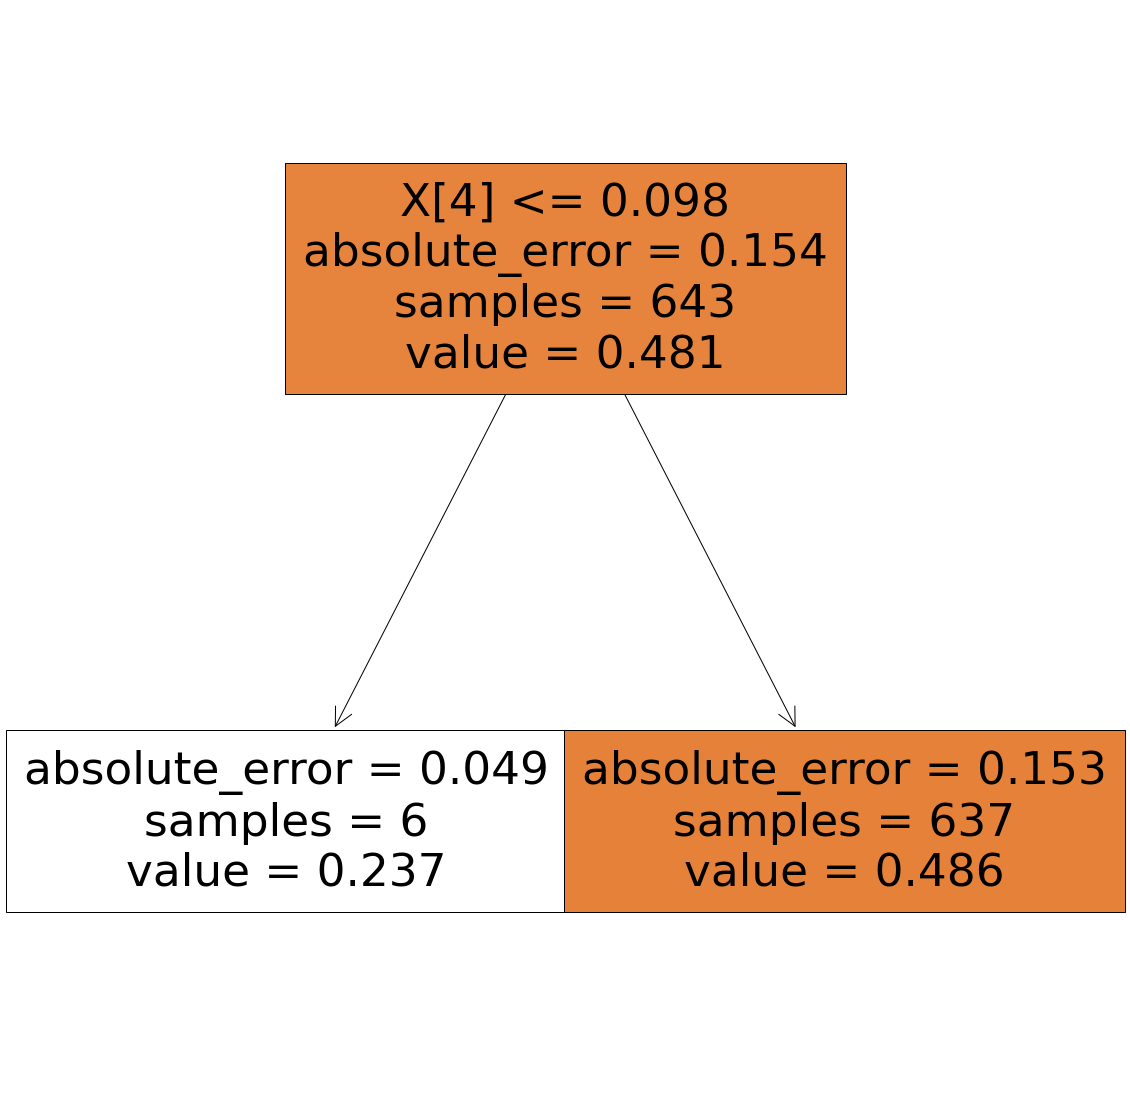

In [29]:
plt.figure(figsize=[20, 20])
tree.plot_tree(dt_mu.model, filled=True)

##Случайный лес (+ GridSearchCV)

In [30]:
param_grid = {
   'criterion': ['squared_error', 'absolute_error'],
   'n_estimators' : [100, 500],
   'max_depth' : [30, 100]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=10).fit(X_train, y_train)
print('Best params: ', grid.best_params_)
print('Best score: ', grid.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

Best params:  {'criterion': 'absolute_error', 'max_depth': 30, 'n_estimators': 500}
Best score:  -0.04127576881378331


In [31]:
results = pd.DataFrame(grid.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7
mean_fit_time,0.695018,3.543135,0.699912,3.446297,3.946436,18.25308,3.721822,18.775347
std_fit_time,0.037732,0.382384,0.049333,0.374867,0.281388,0.518573,0.160419,1.721695
mean_score_time,0.019581,0.071152,0.019026,0.095106,0.017421,0.061311,0.016998,0.059964
std_score_time,0.00398,0.010154,0.003175,0.070647,0.001855,0.007393,0.002885,0.012665
param_criterion,squared_error,squared_error,squared_error,squared_error,absolute_error,absolute_error,absolute_error,absolute_error
param_max_depth,30,30,100,100,30,30,100,100
param_n_estimators,100,500,100,500,100,500,100,500
params,"{'criterion': 'squared_error', 'max_depth': 30...","{'criterion': 'squared_error', 'max_depth': 30...","{'criterion': 'squared_error', 'max_depth': 10...","{'criterion': 'squared_error', 'max_depth': 10...","{'criterion': 'absolute_error', 'max_depth': 3...","{'criterion': 'absolute_error', 'max_depth': 3...","{'criterion': 'absolute_error', 'max_depth': 1...","{'criterion': 'absolute_error', 'max_depth': 1..."
split0_test_score,-0.07364,-0.045426,-0.066406,-0.050134,-0.050732,-0.015943,-0.03561,-0.030288
split1_test_score,0.004445,0.015021,-0.001847,0.003977,0.005038,-0.004589,-0.013257,0.008067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


MAE:  0.16287941193132555
MSE:  0.039246057646507945
R2:  -0.04344042381878466


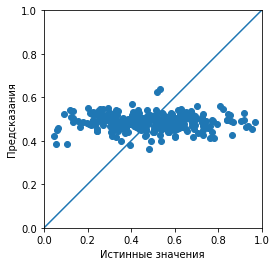

In [32]:
rf_mu = Model(model = RandomForestRegressor( criterion="absolute_error", max_depth=30, n_estimators=500))
rf_mu.fit_and_predict()
rf_mu.print_metrics()
rf_mu.print_plot()

##Нейронная сеть

In [33]:
#Класс обертка
class NNModel:
  def __init__(self, loss='mean_squared_error', optimizer='adam'):
    norm = np.array(X_train)
    self.norm_layer = layers.Normalization(axis=None, input_dim=X_train.shape[1])
    self.norm_layer.adapt(norm)

    self.model = keras.Sequential()
    self.model.add(self.norm_layer)
    self.model.add(Dense(X_train.shape[1], activation='relu'))
    self.model.add(Dense(X_train.shape[1], activation='relu'))
    self.model.add(layers.Dense(1))
    self.model.compile(loss=loss, optimizer=optimizer)
    self.model.summary()
    
  def fit(self):
    self.history = self.model.fit(X_train, y_train, validation_split=0.2, verbose=1, epochs=20, validation_data=(X_test, y_test))

  def plot_model(self):
    print(plot_model(self.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True))

  def predict(self):
    self.y_pred = self.model.predict(X_test).flatten()

  def fit_and_predict(self):
    self.fit()
    self.predict()

  def print_metrics(self):
    self.mae = mean_absolute_error(y_test, self.y_pred)
    self.mse = mean_squared_error(y_test, self.y_pred)
    self.r2 = r2_score(y_test, self.y_pred)

    print('MAE: ', self.mae)
    print('MSE: ', self.mse)
    print('R2: ', self.r2)

  def plot_history(self):
    plt.plot(self.history.history['loss'], label = 'ошибка на обучающей выборке')
    plt.plot(self.history.history['val_loss'], label = 'ошибка на тестовой выборке')
    plt.ylim([0, 3])
    plt.xlabel('Эпоха')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)

  def print_plot(self, lims=[0, 1]):    
    a = plt.axes(aspect='equal')
    plt.scatter(y_test, self.y_pred)
    plt.xlabel('Истинные значения')
    plt.ylabel('Предсказания')
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)

In [34]:
nn_mu = NNModel()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 12)               3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 12)                156       
                                                                 
 dense_1 (Dense)             (None, 12)                156       
                                                                 
 dense_2 (Dense)             (None, 1)                 13        
                                                                 
Total params: 328
Trainable params: 325
Non-trainable params: 3
_________________________________________________________________


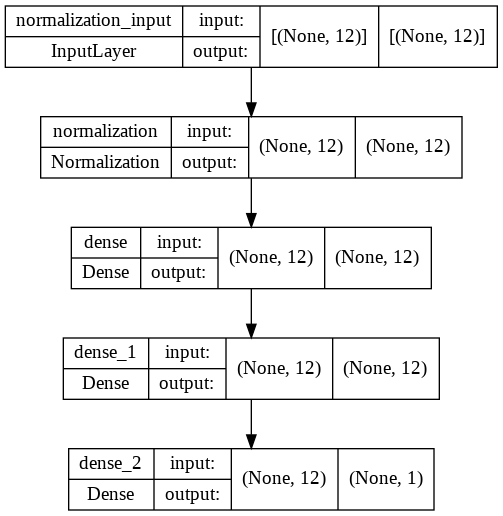

In [35]:
plot_model(nn_mu.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [36]:
nn_mu.fit_and_predict()

Epoch 1/20
17/17 [==============================] - 1s 17ms/step - loss: 0.5256 - val_loss: 0.2949
Epoch 2/20
17/17 [==============================] - 0s 5ms/step - loss: 0.2365 - val_loss: 0.1574
Epoch 3/20
17/17 [==============================] - 0s 5ms/step - loss: 0.1419 - val_loss: 0.1182
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 0.1073 - val_loss: 0.1000
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.0912 - val_loss: 0.0874
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.0798 - val_loss: 0.0790
Epoch 7/20
17/17 [==============================] - 0s 4ms/step - loss: 0.0719 - val_loss: 0.0716
Epoch 8/20
17/17 [==============================] - 0s 3ms/step - loss: 0.0657 - val_loss: 0.0666
Epoch 9/20
17/17 [==============================] - 0s 4ms/step - loss: 0.0610 - val_loss: 0.0626
Epoch 10/20
17/17 [==============================] - 0s 5ms/step - loss: 0.0575 - val_loss: 0.0596
Epoch 11/20
17/17 

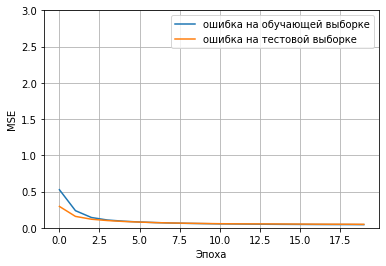

In [37]:
nn_mu.plot_history()

MAE:  0.17978498696150905
MSE:  0.048881119954611425
R2:  -0.2996091730175323


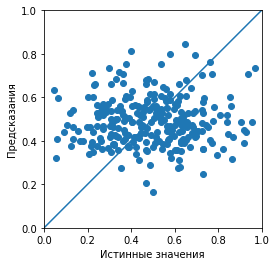

In [38]:
nn_mu.print_metrics()
nn_mu.print_plot();

# Модели для прогноза прочности при растяжении

In [39]:
X = df_norm.copy()
y = pd.DataFrame(data=X.pop('Прочность при растяжении, МПа'), 
                 columns=['Прочность при растяжении, МПа'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=42)

print("Size of train data set: ",  X_train.shape)
print("Size of train label set: ", y_train.shape)
print("Size of test data set: ",   X_test.shape)
print("Size of test label set: ",  y_test.shape)

Size of train data set:  (643, 12)
Size of train label set:  (643, 1)
Size of test data set:  (276, 12)
Size of test label set:  (276, 1)


In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Линейная регрессия

MAE:  0.15368953517630585
MSE:  0.03853390737560863
R2:  -0.06536311747323276


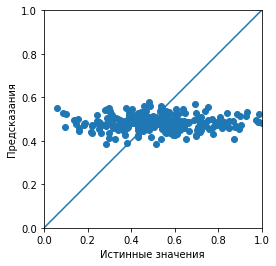

In [41]:
lr_pr = Model(LinearRegression())
lr_pr.fit_and_predict()
lr_pr.print_metrics()
lr_pr.print_plot()

##Дерево решений (+ GridSearchCV)

In [42]:
param_grid = {
   'criterion': ['squared_error'],
   'max_depth' : [1, 2 ,3, 11, 13, 15, 17, 19]
}
grid = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=10).fit(X_train, y_train)
print('Best params: ', grid.best_params_)
print('Best score: ', grid.best_score_)

Best params:  {'criterion': 'squared_error', 'max_depth': 1}
Best score:  -0.029239438279347895


In [43]:
results = pd.DataFrame(grid.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7
mean_fit_time,0.004316,0.00447,0.004969,0.009,0.010915,0.009599,0.00978,0.010424
std_fit_time,0.001451,0.00023,0.000241,0.000403,0.002476,0.00102,0.000601,0.001328
mean_score_time,0.002898,0.002892,0.002821,0.003675,0.004046,0.002718,0.00262,0.002803
std_score_time,0.000708,0.00031,0.000241,0.000432,0.000825,0.000212,0.000298,0.000423
param_criterion,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error,squared_error
param_max_depth,1,2,3,11,13,15,17,19
params,"{'criterion': 'squared_error', 'max_depth': 1}","{'criterion': 'squared_error', 'max_depth': 2}","{'criterion': 'squared_error', 'max_depth': 3}","{'criterion': 'squared_error', 'max_depth': 11}","{'criterion': 'squared_error', 'max_depth': 13}","{'criterion': 'squared_error', 'max_depth': 15}","{'criterion': 'squared_error', 'max_depth': 17}","{'criterion': 'squared_error', 'max_depth': 19}"
split0_test_score,-0.000849,-0.033842,-0.026013,-0.718942,-0.818135,-1.125073,-1.122171,-1.221763
split1_test_score,-0.055651,-0.078849,-0.034615,-0.403937,-0.662575,-0.860346,-0.710951,-0.715382
split2_test_score,-0.016304,-0.026211,-0.039656,-0.681008,-0.770754,-1.008649,-1.017896,-1.06511


MAE:  0.15180851037694262
MSE:  0.03774053558517573
R2:  -0.0434284344489535


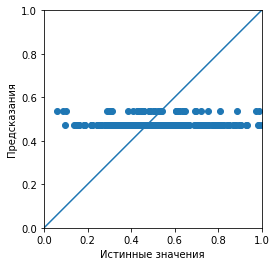

In [44]:
dt_pr = Model(model = DecisionTreeRegressor(criterion='squared_error', max_depth=1))
dt_pr.fit_and_predict()
dt_pr.print_metrics()
dt_pr.print_plot()

[Text(0.5, 0.75, 'X[1] <= 0.326\nsquared_error = 0.034\nsamples = 643\nvalue = 0.487'),
 Text(0.25, 0.25, 'squared_error = 0.032\nsamples = 120\nvalue = 0.537'),
 Text(0.75, 0.25, 'squared_error = 0.034\nsamples = 523\nvalue = 0.475')]

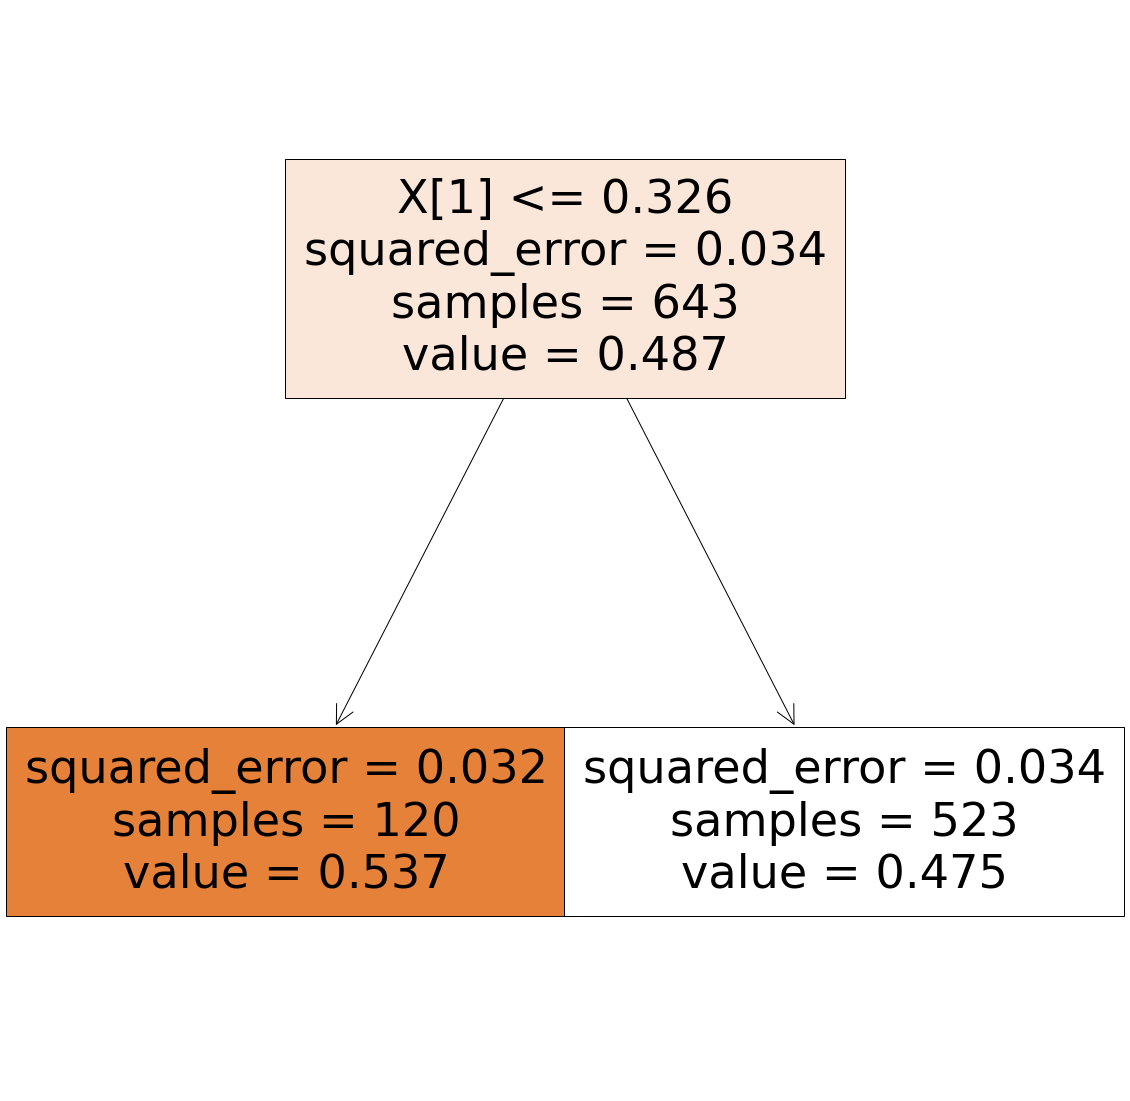

In [45]:
plt.figure(figsize=[20, 20])
tree.plot_tree(dt_pr.model, filled=True)

##Случайный лес (+ GridSearchCV)

In [46]:
param_grid = {
   'criterion': ['squared_error', 'absolute_error'],
   'n_estimators' : [100, 500],
   'max_depth' : [30, 100]
}
grid = GridSearchCV(RandomForestRegressor(), param_grid, cv=10).fit(X_train, y_train)
print('Best params: ', grid.best_params_)
print('Best score: ', grid.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 

Best params:  {'criterion': 'absolute_error', 'max_depth': 100, 'n_estimators': 500}
Best score:  -0.043433428509049


In [47]:
results = pd.DataFrame(grid.cv_results_)
display(results.T)

,0,1,2,3,4,5,6,7
mean_fit_time,0.536238,3.464612,0.569272,2.695811,3.939919,19.104425,3.827478,18.947483
std_fit_time,0.019522,1.162454,0.019234,0.117396,0.404329,0.885286,0.214384,0.884602
mean_score_time,0.012835,0.063215,0.01352,0.051702,0.014318,0.05311,0.014147,0.055459
std_score_time,0.00072,0.025005,0.000783,0.004027,0.002691,0.008126,0.000867,0.00674
param_criterion,squared_error,squared_error,squared_error,squared_error,absolute_error,absolute_error,absolute_error,absolute_error
param_max_depth,30,30,100,100,30,30,100,100
param_n_estimators,100,500,100,500,100,500,100,500
params,"{'criterion': 'squared_error', 'max_depth': 30...","{'criterion': 'squared_error', 'max_depth': 30...","{'criterion': 'squared_error', 'max_depth': 10...","{'criterion': 'squared_error', 'max_depth': 10...","{'criterion': 'absolute_error', 'max_depth': 3...","{'criterion': 'absolute_error', 'max_depth': 3...","{'criterion': 'absolute_error', 'max_depth': 1...","{'criterion': 'absolute_error', 'max_depth': 1..."
split0_test_score,-0.062083,-0.033681,-0.060032,-0.051648,-0.025118,-0.007527,-0.009325,0.00621
split1_test_score,0.003169,0.010756,0.008532,-0.008679,-0.053244,-0.030322,-0.04477,-0.017887


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


MAE:  0.15176072980454042
MSE:  0.03775869999281953
R2:  -0.04393063345425596


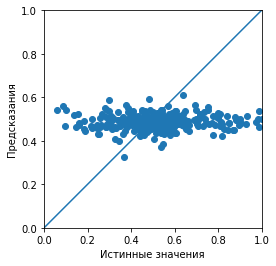

In [48]:
rf_pr = Model(model = RandomForestRegressor( criterion="absolute_error", max_depth=30, n_estimators=500))
rf_pr.fit_and_predict()
rf_pr.print_metrics()
rf_pr.print_plot()

##Нейронная сеть

In [49]:
nn_pr = NNModel()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 12)               3         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 12)                156       
                                                                 
 dense_4 (Dense)             (None, 12)                156       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 328
Trainable params: 325
Non-trainable params: 3
_________________________________________________________________


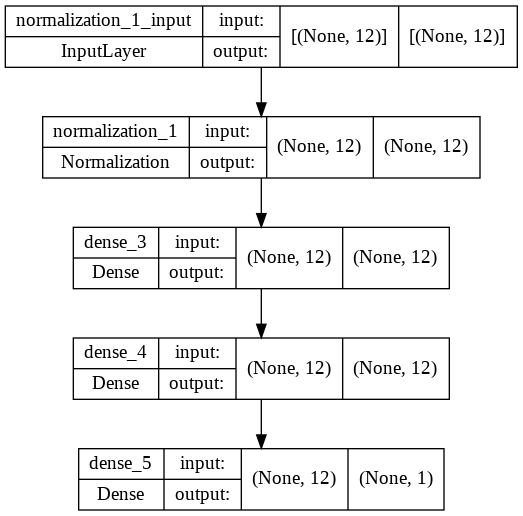

In [50]:
plot_model(nn_pr.model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [51]:
nn_pr.fit_and_predict()

Epoch 1/20
17/17 [==============================] - 1s 12ms/step - loss: 0.6918 - val_loss: 0.5506
Epoch 2/20
17/17 [==============================] - 0s 4ms/step - loss: 0.3540 - val_loss: 0.2893
Epoch 3/20
17/17 [==============================] - 0s 3ms/step - loss: 0.1853 - val_loss: 0.1752
Epoch 4/20
17/17 [==============================] - 0s 3ms/step - loss: 0.1257 - val_loss: 0.1396
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 0.1090 - val_loss: 0.1233
Epoch 6/20
17/17 [==============================] - 0s 4ms/step - loss: 0.0952 - val_loss: 0.1131
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 0.0850 - val_loss: 0.1053
Epoch 8/20
17/17 [==============================] - 0s 4ms/step - loss: 0.0783 - val_loss: 0.0991
Epoch 9/20
17/17 [==============================] - 0s 4ms/step - loss: 0.0722 - val_loss: 0.0939
Epoch 10/20
17/17 [==============================] - 0s 4ms/step - loss: 0.0676 - val_loss: 0.0892
Epoch 11/20
17/17 

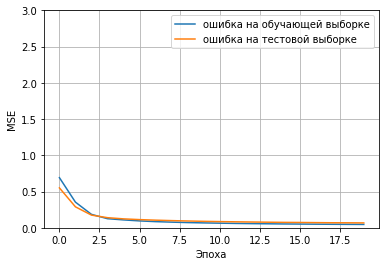

In [52]:
nn_pr.plot_history()

MAE:  0.19425332289791386
MSE:  0.05949291913088777
R2:  -0.6448257160908908


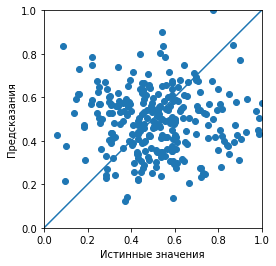

In [53]:
nn_pr.print_metrics()
nn_pr.print_plot();

# Сводная таблица моделей

In [54]:
df_mu = pd.DataFrame(index=['Линейная регрессия', 'Дерево решений','Случайный лес',  'Нейронная сеть'], columns=['MAE', 'MSE', 'R2'])
df_mu['Линейная регрессия':] = [lr_mu.mae, lr_mu.mse, lr_mu.r2]
df_mu['Дерево решений':] = [dt_mu.mae, dt_mu.mse, dt_mu.r2]
df_mu['Случайный лес':] = [rf_mu.mae, rf_mu.mse, rf_mu.r2]
df_mu['Нейронная сеть':] = [nn_mu.mae, nn_mu.mse, nn_mu.r2]

df_pr = pd.DataFrame(index=['Линейная регрессия', 'Дерево решений','Случайный лес',  'Нейронная сеть'], columns=['MAE', 'MSE', 'R2'])
df_pr['Линейная регрессия':] = [lr_pr.mae, lr_pr.mse, lr_pr.r2]
df_pr['Дерево решений':] = [dt_pr.mae, dt_pr.mse, dt_pr.r2]
df_pr['Случайный лес':] = [rf_pr.mae, rf_pr.mse, rf_pr.r2]
df_pr['Нейронная сеть':] = [nn_pr.mae, nn_pr.mse, nn_pr.r2]

In [55]:
print()
print('\033[1m' + 'Модели для прогноза модуля упругости при растяжении' + '\033[0m')
print(tabulate(df_mu, headers='keys', tablefmt='psql'))
print()
print('\033[1m' + 'Модели для прогноза прочности при растяжении' + '\033[0m')
print(tabulate(df_pr, headers='keys', tablefmt='psql'))


Модели для прогноза модуля упругости при растяжении
+--------------------+----------+-----------+-------------+
|                    |      MAE |       MSE |          R2 |
|--------------------+----------+-----------+-------------|
| Линейная регрессия | 0.159633 | 0.038589  | -0.0259701  |
| Дерево решений     | 0.15958  | 0.0377647 | -0.00405595 |
| Случайный лес      | 0.162879 | 0.0392461 | -0.0434404  |
| Нейронная сеть     | 0.179785 | 0.0488811 | -0.299609   |
+--------------------+----------+-----------+-------------+

Модели для прогноза прочности при растяжении
+--------------------+----------+-----------+------------+
|                    |      MAE |       MSE |         R2 |
|--------------------+----------+-----------+------------|
| Линейная регрессия | 0.15369  | 0.0385339 | -0.0653631 |
| Дерево решений     | 0.151809 | 0.0377405 | -0.0434284 |
| Случайный лес      | 0.151761 | 0.0377587 | -0.0439306 |
| Нейронная сеть     | 0.194253 | 0.0594929 | -0.644826  |
+-------

#Рекомендательная нейросеть для соотношения матрица-наполнитель

In [56]:
X = df.copy()
y = pd.DataFrame(data=X.pop('Соотношение матрица-наполнитель'), columns=['Соотношение матрица-наполнитель'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Size of train data set: ",  X_train.shape)
print("Size of train label set: ", y_train.shape)
print("Size of test data set: ",   X_test.shape)
print("Size of test label set: ",  y_test.shape)

Size of train data set:  (643, 12)
Size of train label set:  (643, 1)
Size of test data set:  (276, 12)
Size of test label set:  (276, 1)


In [57]:
nn_mf = NNModel()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_2 (Normalizat  (None, 12)               3         
 ion)                                                            
                                                                 
 dense_6 (Dense)             (None, 12)                156       
                                                                 
 dense_7 (Dense)             (None, 12)                156       
                                                                 
 dense_8 (Dense)             (None, 1)                 13        
                                                                 
Total params: 328
Trainable params: 325
Non-trainable params: 3
_________________________________________________________________


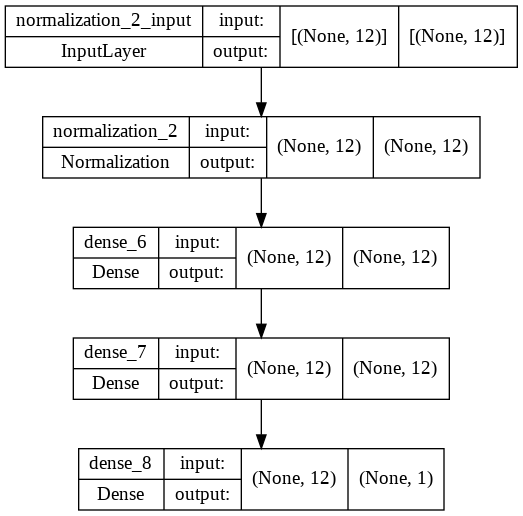

In [58]:
plot_model(nn_mf.model, to_file='model_plot.png', show_shapes=True,
           show_layer_names=True)

In [59]:
nn_mf.fit_and_predict()

Epoch 1/20
17/17 [==============================] - 1s 12ms/step - loss: 9.2618 - val_loss: 9.5636
Epoch 2/20
17/17 [==============================] - 0s 3ms/step - loss: 8.4483 - val_loss: 8.8450
Epoch 3/20
17/17 [==============================] - 0s 4ms/step - loss: 7.7987 - val_loss: 8.2512
Epoch 4/20
17/17 [==============================] - 0s 4ms/step - loss: 7.2838 - val_loss: 7.7365
Epoch 5/20
17/17 [==============================] - 0s 4ms/step - loss: 6.7663 - val_loss: 7.1766
Epoch 6/20
17/17 [==============================] - 0s 3ms/step - loss: 6.2155 - val_loss: 6.5609
Epoch 7/20
17/17 [==============================] - 0s 3ms/step - loss: 5.6026 - val_loss: 5.8896
Epoch 8/20
17/17 [==============================] - 0s 3ms/step - loss: 4.9265 - val_loss: 5.1656
Epoch 9/20
17/17 [==============================] - 0s 5ms/step - loss: 4.2235 - val_loss: 4.3893
Epoch 10/20
17/17 [==============================] - 0s 3ms/step - loss: 3.4946 - val_loss: 3.6170
Epoch 11/20
17/17 

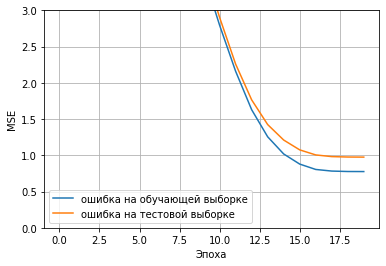

In [60]:
nn_mf.plot_history()

MAE:  0.7529630048280076
MSE:  0.8525619071439539
R2:  -0.025004005511227057


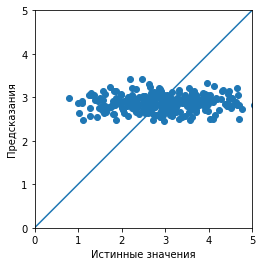

In [61]:
nn_mf.print_metrics()
nn_mf.print_plot(lims=[0, 5]);

#Сериализация модели

In [62]:
pickle.dump(nn_mf.model, 
            open('/content/drive/MyDrive/Datasets/MGTU-DS-VKR-2022/mf.pkl',
                 'wb'))

INFO:tensorflow:Assets written to: ram://13b53256-fbd8-4eec-9f23-da7840e8153e/assets


In [63]:
loaded_nn_mf = pickle.load(
    open('/content/drive/MyDrive/Datasets/MGTU-DS-VKR-2022/mf.pkl', 'rb'))

In [64]:
X_test[:1]

,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
80,1988.301966,177.034495,52.074364,16.977083,292.072967,793.834135,75.102747,2371.373132,172.99571,0.0,5.867705,59.620426


In [65]:
loaded_nn_mf.predict(X_test[:1])

array([[2.5918632]], dtype=float32)

In [66]:
y_test[:1]

,Соотношение матрица-наполнитель
80,3.107885
